In [1]:
import pandas as pd

data = pd.read_csv('table.csv')
data.head()

,Unnamed: 0,partisan,level,type,candidates,mean gamma,stdev,total number of elections
0,0,DP,Federal,E,9,0.576628,NaN,1
1,1,Yes,Federal,R,3,0.914758,0.047078,3
2,2,Yes,State,E,4,0.815945,NaN,1
3,3,Yes,State,R,2,1.000000,0.000000,20
4,4,Yes,State,R,1,1.000000,0.000000,6


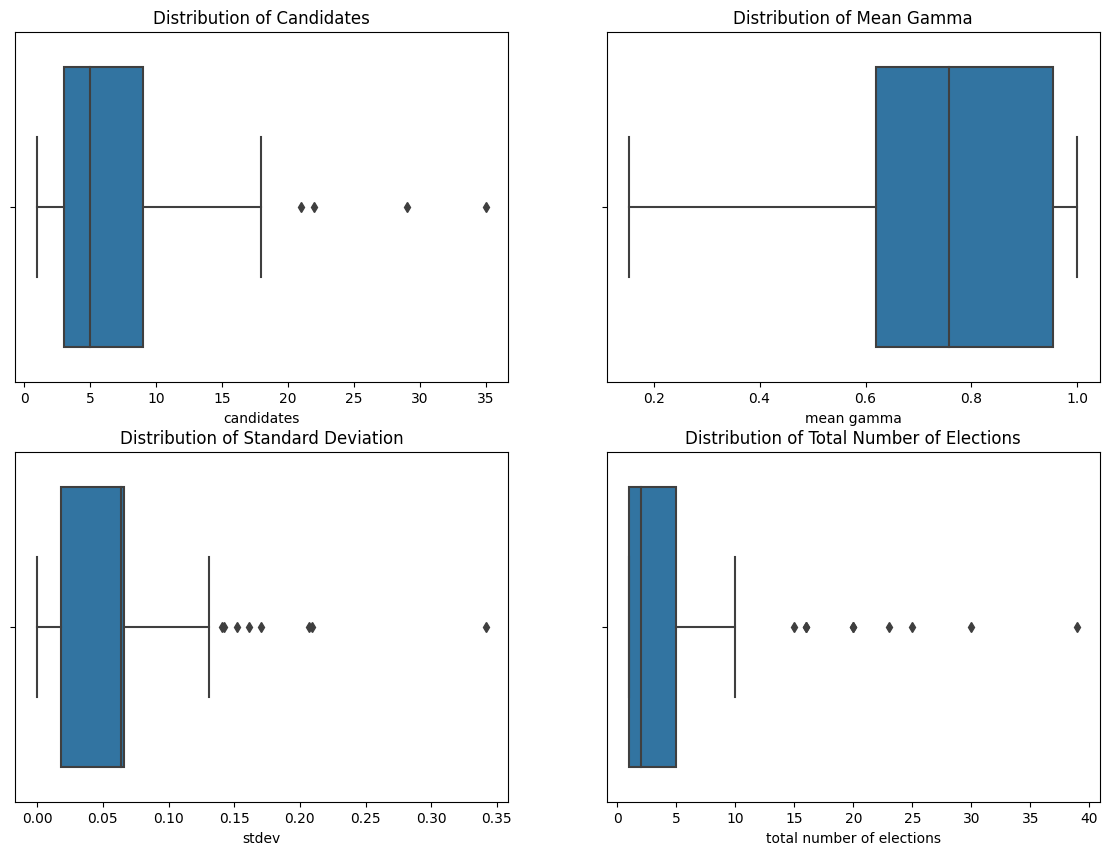

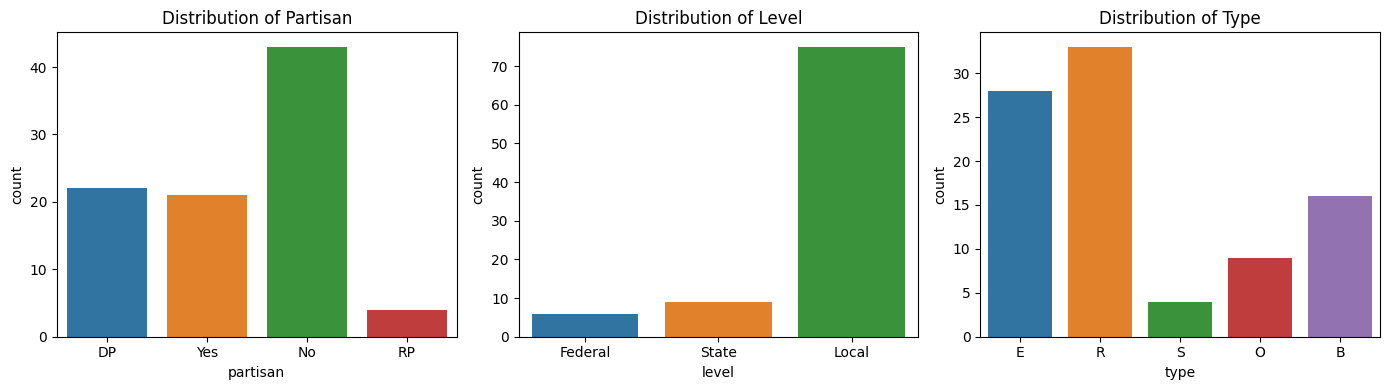

,Unnamed: 0,partisan,level,type,candidates,mean gamma,stdev,total number of elections
count,90.000000,90,90,90,90.000000,90.000000,90.000000,90.000000
unique,NaN,4,3,5,NaN,NaN,NaN,NaN
top,NaN,No,Local,R,NaN,NaN,NaN,NaN
freq,NaN,43,75,33,NaN,NaN,NaN,NaN
mean,46.722222,NaN,NaN,NaN,6.888889,0.757172,0.063883,4.877778
std,26.967741,NaN,NaN,NaN,5.944395,0.202370,0.054784,6.821690
min,0.000000,NaN,NaN,NaN,1.000000,0.153821,0.000000,1.000000
25%,24.250000,NaN,NaN,NaN,3.000000,0.619332,0.017887,1.000000
50%,46.500000,NaN,NaN,NaN,5.000000,0.758310,0.063883,2.000000
75%,69.750000,NaN,NaN,NaN,9.000000,0.953562,0.066201,5.000000


In [2]:
# Fill the missing values in 'stdev' column with the mean of the non-missing values.
data['stdev'].fillna(data['stdev'].mean(), inplace=True)

# Summary statistics for each variable
summary = data.describe(include='all')

# Boxplots to visualize the distribution of numeric variables
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x=data['candidates'], ax=axs[0, 0]).set_title('Distribution of Candidates')
sns.boxplot(x=data['mean gamma'], ax=axs[0, 1]).set_title('Distribution of Mean Gamma')
sns.boxplot(x=data['stdev'], ax=axs[1, 0]).set_title('Distribution of Standard Deviation')
sns.boxplot(x=data['total number of elections'], ax=axs[1, 1]).set_title('Distribution of Total Number of Elections')

# Bar plots to visualize the distribution of categorical variables
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(x=data['partisan'], ax=axs[0]).set_title('Distribution of Partisan')
sns.countplot(x=data['level'], ax=axs[1]).set_title('Distribution of Level')
sns.countplot(x=data['type'], ax=axs[2]).set_title('Distribution of Type')

plt.tight_layout()
plt.show()

summary

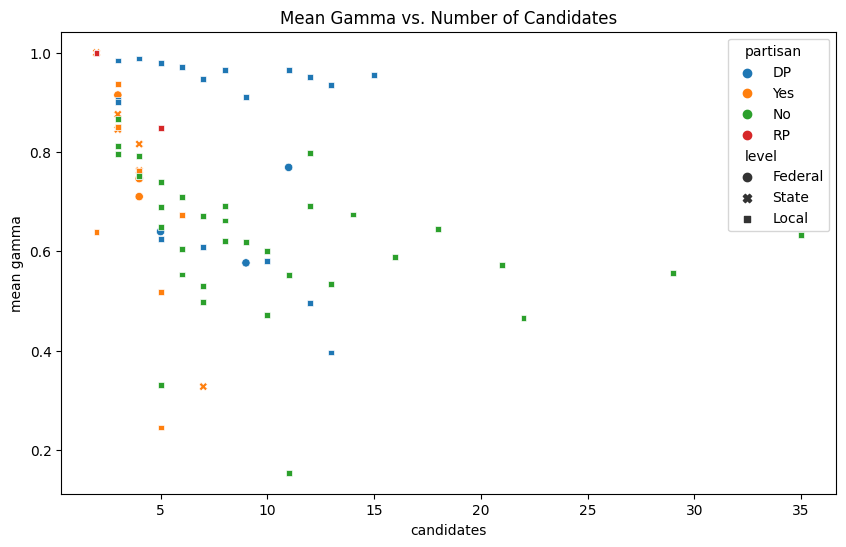

In [3]:
# Remove rows where the number of candidates is less than 2
filtered_data = data[data['candidates'] >= 2]

# Visualize the relationship between the number of candidates and mean gamma
plt.figure(figsize=(10, 6))
sns.scatterplot(x='candidates', y='mean gamma', hue='partisan', style='level', data=filtered_data)
plt.title('Mean Gamma vs. Number of Candidates')
plt.show()

<Figure size 1400x1000 with 0 Axes>

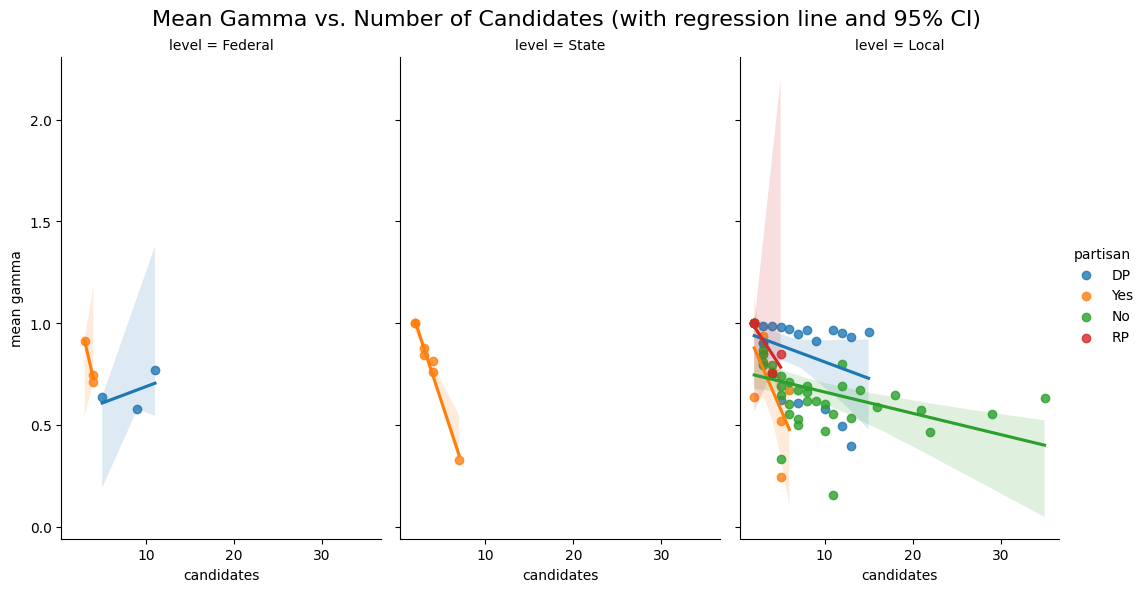

In [4]:
# Relationship between the number of candidates and mean gamma with a trend line for each category
plt.figure(figsize=(14, 10))

sns.lmplot(x='candidates', y='mean gamma', hue='partisan', col='level', data=filtered_data, ci=95, height=6, aspect=0.6)

plt.subplots_adjust(top=0.9)
plt.suptitle('Mean Gamma vs. Number of Candidates (with regression line and 95% CI)', fontsize=16)
plt.show()

In [5]:
# Drop the first level of each categorical variable to prevent multicollinearity
data_encoded = pd.get_dummies(filtered_data, columns=['partisan', 'level', 'type'], drop_first=True)

# Let's import the required function and fit a linear mixed-effects model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Construct the formula
formula = 'Q("mean gamma") ~ candidates + ' + ' + '.join(data_encoded.columns.difference(['Unnamed: 0', 'candidates', 'mean gamma', 'stdev', 'total number of elections']))

# Fit the model
mixed_model = smf.ols(formula, data=data_encoded)
mixed_model_fit = mixed_model.fit()

# Show the model summary
mixed_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("mean gamma")   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     4.821
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           2.61e-05
Time:                        10:03:04   Log-Likelihood:                 38.493
No. Observations:                  84   AIC:                            -54.99
Df Residuals:                      73   BIC:                            -28.25
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.7900      0.100      7.887      0.000       0.590       0.990
level_Local[T.True]      0.0335      0.078      0.428      0.670      -0.123       0.190
level_State[T.True]      0.0853      0.097      0.879      0.382      -0.108       0.279
partisan_No[T.True]     -0.0943      0.050     -1.881      0.064      -0.194       0.006
partisan_RP[T.True]      0.0499      0.092      0.542      0.589      -0.133       0.233
partisan_Yes[T.True]    -0.1447      0.064     -2.272      0.026      -0.272      -0.018
type_E[T.True]          -0.0241      0.058     -0.418      0.677      -0.139       0.091
type_O[T.True]           0.1010      0.078      1.291      0.201      -0.055       0.257
type_R[T.True]           0.1420      0.062      2.289      0.025       0.018       0.266
type_S[T.True]           0.1891      0.124      1.531      0.130      -0.057       0.435
candidates              -0.0097      0.003     -2.833      0.006      -0.017      -0.003
==============================================================================
Omnibus:                       14.791   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.734
Skew:                          -0.870   Prob(JB):                     0.000141
Kurtosis:                       4.428   Cond. No.                         81.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

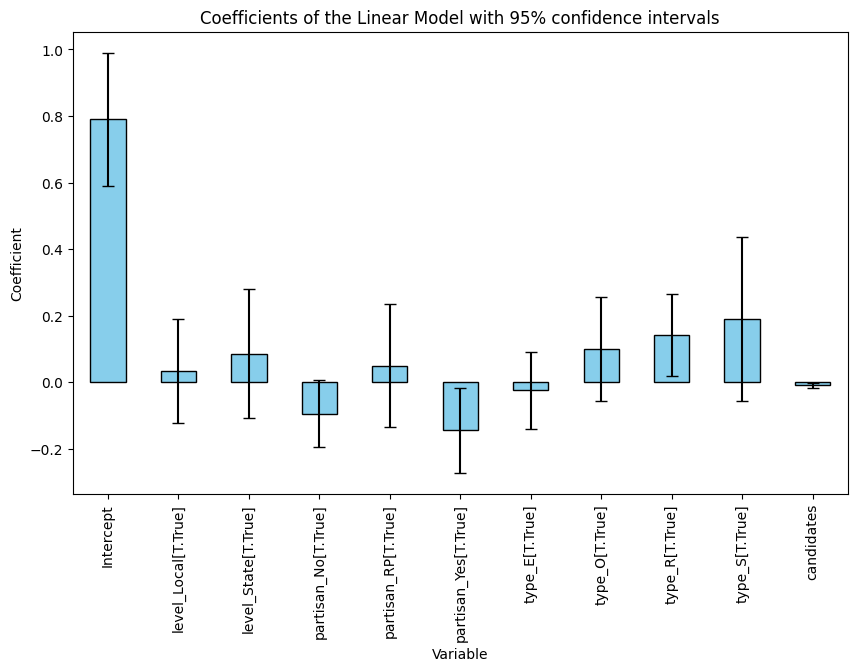

In [6]:
# Get the coefficients and their errors
coefficients = mixed_model_fit.params
errors = mixed_model_fit.bse

# Plot
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar', yerr=errors*2, capsize=4, color='skyblue', edgecolor='black')
plt.title('Coefficients of the Linear Model with 95% confidence intervals')
plt.ylabel('Coefficient')
plt.xlabel('Variable')
plt.show()